**Submitted by:** 
          
          Name: Ayush Koirala
          id : st122802

**Assignment on Glove **

Constraint: Only use our code (not other code....)

1. I guess you already try a bigger corpus
2. I guess you already try window size 2
3. I guess you already have skipgram, skipgram(neg), cbow, glove

Do this:
1. Compare them based on syntactic accuracy and semantic accuracy, similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) - NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....
2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

Point criteria:
0:  Not done
1: ok
2: with comments / explanation / figures.




**Importing Libraries**

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy

**ETL**

In [2]:
import nltk 
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [3]:
corpus = brown.sents()[:1000]
#Transforming to lower case
corpus = [[word.lower() for word in sent] for sent in corpus] # Cool list comprehension trick!
print(corpus[0:5])

[['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['the', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'city', 'executive', 'committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'city', 'of', 'atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['the', 'september-october', 'term', 'jury', 'had', 'been', 'charged', 'by', 'fulton', 'superior', 'court', 'judge', 'durwood', 'pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'mayor-nominate', 'ivan', 'allen', 'jr.', '.'], ['``', 'only', 'a', 'relative', 'handful', 'of', 'such', 'rep

In [4]:
print(len(corpus))

1000


**Doing flatten and Get word sequences and unique words**

In [5]:
# Doing flatten and Get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab[:5]

['caldwell', 'list', 'after', 'tea', 'twelve']

In [6]:
len(vocab)

4272

**Numericalize**

In [6]:
import itertools

word2index = {w: i for i, w in enumerate(vocab)}
index2word = {v:k for k, v in word2index.items()}

out = dict(itertools.islice(word2index.items(), 5))
print(out)

{'caldwell': 0, 'list': 1, 'after': 2, 'tea': 3, 'twelve': 4}


In [7]:
vocab.append('<UNK>')
word2index['<UNK>'] = 0

**Glove Method**

In [ ]:
#2. Build Co-occurence Matrix X and displaying only first 5
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
out = dict(itertools.islice(X_i.items(), 5))
print(out)

{'the': 1569, 'fulton': 14, 'county': 35, 'grand': 7, 'jury': 23}


In [ ]:
#modifing previous assignment random batch
def random_batch_skipgram(corpus,window_size=1):
    skip_grams = []
    for sent in corpus:
        for i in range(1, len(sent) - 1):  # we should start  from 1 because 0 has no context
            target = sent[i]
            context = []
            for j in range(window_size):
                if i - (j + 1) >= 0:  ## Checking  if anything fall outside of range from the left of list
                     context.append(sent[i - (j + 1)])
                if i + (j + 1) < len(sent): 
                     context.append(sent[i + (j + 1)])
            for w in context:
                skip_grams.append((target,w))
    return skip_grams

**Find co-occurance in skip_grams with window of 2**

In [ ]:
X_ik_skipgram = Counter(random_batch_skipgram(corpus,window_size=2))

out = dict(itertools.islice(X_ik_skipgram.items(), 5))
print(out)

{('fulton', 'the'): 7, ('fulton', 'county'): 6, ('fulton', 'grand'): 1, ('county', 'fulton'): 6, ('county', 'grand'): 1}


**Weight function**

In [ ]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [ ]:
#from itertools import combinations_with_replacement
from itertools import combinations_with_replacement
from tqdm import tqdm

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in tqdm(combinations_with_replacement(vocab, 2)):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

print(f"{X_ik=}")
print(f"{weighting_dic=}")

9131401it [00:28, 321349.78it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

In [ ]:
#testing the method
batch_size = 2 # mini-batch size
skip_grams = random_batch_skipgram(corpus,window_size=2)
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)


Input:  [[1543]
 [3056]]
Target:  [[1079]
 [4058]]
Cooc:  [[1.09861229]
 [0.69314718]]
Weighting:  [[0.07208434]
 [0.05318296]]


In [46]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

**Glove Training**

In [8]:
# Trying to use Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
voc_size = len(vocab)
batch_size     = 10 # mini-batch size
embedding_size = 100 #so we can later plot
model          = GloVe(voc_size, embedding_size)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch).to(device)          #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch).to(device)          #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch).to(device)           #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch).to(device)   #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 1000 | cost: 115.496872 | time: 0m 0s
Epoch: 2000 | cost: 98.368538 | time: 0m 0s
Epoch: 3000 | cost: 80.760368 | time: 0m 0s
Epoch: 4000 | cost: 24.985233 | time: 0m 0s
Epoch: 5000 | cost: 24.683460 | time: 0m 0s


In [ ]:
# Save model
path = '/content/Glove_5000.pth'
torch.save(model.state_dict(), path)

**Now Trying for SkipGram**

Taking everything from 1st assigment

In [73]:
def random_batch(batch_size, word_sequence, window_size=1):
    skip_grams = []
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = []
            for j in range(window_size):
                if i - (j + 1) >= 0: 
                    context.append(word2index[sent[i - (j + 1)]])
                
                if i + (j + 1) < len(sent): 
                    context.append(word2index[sent[i + (j + 1)]])
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) 
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  
        random_labels.append([skip_grams[i][1]])  
            
    return np.array(random_inputs), np.array(random_labels)

In [ ]:
#testing
batch_size =2 
window_size = 2

input_batch, target_batch = random_batch(batch_size, corpus, window_size)

print("Input: ", input_batch)
print("Target: ", target_batch)


Input:  [[2203]
 [1079]]
Target:  [[4097]
 [4020]]


In [100]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [10]:
voc_size = len(vocab)
voc_size

4273

In [11]:
batch_size = 10

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([10, 4273])

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
window_size=2
model  = Skipgram(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
import time

# Training
start_train_time = time.time()
num_epochs = 1000
start = time.time()
for epoch in range(num_epochs):
    
    input_batch, target_batch = random_batch(batch_size, corpus, window_size)
    input_batch  = torch.LongTensor(input_batch) #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        end = time.time()
        epoch_mins, epoch_secs = epoch_time(start, end)
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 100 | cost: 9.959069 | time: 0m 15s
Epoch: 200 | cost: 11.423738 | time: 0m 30s
Epoch: 300 | cost: 9.541531 | time: 0m 45s
Epoch: 400 | cost: 8.458012 | time: 1m 0s
Epoch: 500 | cost: 8.943056 | time: 1m 15s
Epoch: 600 | cost: 8.225544 | time: 1m 31s
Epoch: 700 | cost: 8.510216 | time: 1m 46s
Epoch: 800 | cost: 7.950565 | time: 2m 1s
Epoch: 900 | cost: 8.315861 | time: 2m 16s
Epoch: 1000 | cost: 9.020043 | time: 2m 31s


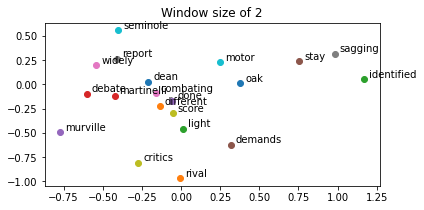

In [ ]:
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_center_word(id_tensor)
    u_embed = model.embedding_outside_word(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.title('Window size of 2')
plt.show()

In [ ]:
# Save model
path = '/content/Skipgrams_1000.pth'
torch.save(model.state_dict(), path)

**CBOW**

Copying everything from 1st assignment

In [38]:
# Random batch for cbow

# Random batch for cbow

def random_batch_cbow(batch_size, word_sequence, window_size=1):

    cbow = []

    for sent in corpus:
        for i in range(1, len(sent) - 1): # So we can modify the window size
            target = word2index[sent[i]]
            context = list()
            
            for j in range(window_size):
                
                if i - (j + 1) >= 0: # Check if it outside of range from the left of list
                    context.append(word2index[sent[i - (j + 1)]])
                
                if i + (j + 1) < len(sent): # Check if it outside of range from the right of list
                    context.append(word2index[sent[i + (j + 1)]])
            
            # This part is different from skipgram
            # Now we use all context as input and target as label
            for w in context:
                cbow.append([context, target])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(cbow)), batch_size, replace=False) #randomly pick without replacement
    
    for i in random_index:
        random_inputs.append(cbow[i][0])  # Context word that we want as input
        random_labels.append([cbow[i][1]])  # Target word that we want as label
    
    return np.array(random_inputs), np.array(random_labels)

In [39]:
 # mini-batch size
batch_size = 2
input_batch, target_batch = random_batch_cbow(batch_size, corpus, 2)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[1419 3637 2021 1033]
 [1085 1263 3734 2114]]
Target:  [[3830]
 [1021]]


In [79]:
class Cbow(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Cbow, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [42]:
batch_size     = 10 # mini-batch size
embedding_size = 100 #so we can later plot
model = Cbow(voc_size, embedding_size)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
all_vocabs = all_vocabs.to(device)

In [45]:
# Training
import time
num_epochs = 500
start = time.time()
for epoch in range(num_epochs):
    
    input_batch, target_batch = random_batch_cbow(batch_size, corpus, 1)
    input_batch  = torch.LongTensor(input_batch).to(device)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch).to(device) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        end = time.time()
        epoch_mins, epoch_secs = epoch_time(start, end)
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
        start = time.time()

Epoch: 100 | cost: 34.562569 | time: 0m 11s
Epoch: 200 | cost: 24.776230 | time: 0m 10s
Epoch: 300 | cost: 32.017139 | time: 0m 10s
Epoch: 400 | cost: 30.892143 | time: 0m 14s
Epoch: 500 | cost: 29.277050 | time: 0m 13s


**Saving Model**


In [46]:
# Save model
path = '/content/CBow_model_500.pth'
torch.save(model.state_dict(), path)

**Negative Sampling**

In [12]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])


In [13]:
# Create unigram table
Z = 0.001
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [16]:


print(unigram_table)

['after', 'after', 'after', 'after', 'after', 'after', 'after', 'known', 'member', 'member', 'set', "organization's", 'b.', 'b.', 'university', 'university', 'stand', 'stand', 'then', 'then', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'th

In [17]:
import random

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    
    return torch.cat(neg_samples)

In [23]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

In [24]:
# Initialize parameter
batch_size     = 10 # mini-batch size
embedding_size = 100 #so we can later plot
model          = SkipgramNegSampling(voc_size, embedding_size)
num_neg        = 10 # num of negative sampling

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
import time

start_train_time = time.time()

# Training
num_epochs = 1000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch = random_batch(batch_size, corpus, 2)
    
    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    
    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    
    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    optimizer.zero_grad()
        
    loss = model(input_batch, target_batch, negs_batch)
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 100 | cost: 15.262489 | time: 0m 0s
Epoch: 200 | cost: 19.257448 | time: 0m 0s
Epoch: 300 | cost: 16.329243 | time: 0m 0s
Epoch: 400 | cost: 9.641607 | time: 0m 0s
Epoch: 500 | cost: 16.024637 | time: 0m 0s
Epoch: 600 | cost: 9.736855 | time: 0m 0s
Epoch: 700 | cost: 11.180909 | time: 0m 0s
Epoch: 800 | cost: 32.525230 | time: 0m 0s
Epoch: 900 | cost: 14.299477 | time: 0m 0s
Epoch: 1000 | cost: 21.399591 | time: 0m 0s


In [31]:
# Save model
path = '/content/Neg_Skipgrams_1000.pth'
torch.save(model.state_dict(), path)

**Testing**

In [32]:
# Load the data
def read_data(path):
    file = open(path, 'r') # Dataset from amamda
    contents = file.read()
    contents = contents.split('\n') # Seperate chunk of text into substring
    file.close()
    return contents

path = '/content/questions-words.txt'
text = read_data(path)
print(text[0:10])

[': capital-common-countries', 'Athens Greece Baghdad Iraq', 'Athens Greece Bangkok Thailand', 'Athens Greece Beijing China', 'Athens Greece Berlin Germany', 'Athens Greece Bern Switzerland', 'Athens Greece Cairo Egypt', 'Athens Greece Canberra Australia', 'Athens Greece Hanoi Vietnam', 'Athens Greece Havana Cuba']


**Find the seperator name and index**

In [33]:
seperator = [(idx, sent) for idx, sent in enumerate(text) if sent[0] == ':']
seperator 

[(0, ': capital-common-countries'),
 (507, ': capital-world'),
 (5032, ': currency'),
 (5899, ': city-in-state'),
 (8367, ': family'),
 (8874, ': gram1-adjective-to-adverb'),
 (9867, ': gram2-opposite'),
 (10680, ': gram3-comparative'),
 (12013, ': gram4-superlative'),
 (13136, ': gram5-present-participle'),
 (14193, ': gram6-nationality-adjective'),
 (15793, ': gram7-past-tense'),
 (17354, ': gram8-plural'),
 (18687, ': gram9-plural-verbs')]

In [37]:
# Let's use comparative and nationality-adjective
comparative = text[10681:12012]
nationality = text[14194:15793]

# Concatenate
test_text = comparative + nationality

# Checking
print(test_text[0])
print(test_text[-1])

bad worse big bigger
Ukraine Ukrainian Switzerland Swiss


In [39]:
#Now split the words
test_comparative = [sent.split(" ") for sent in comparative]
test_nationality = [sent.split(" ") for sent in nationality]
test_corpus = [sent.split(" ") for sent in test_text]
print(test_corpus[0:5])


[['bad', 'worse', 'big', 'bigger'], ['bad', 'worse', 'bright', 'brighter'], ['bad', 'worse', 'cheap', 'cheaper'], ['bad', 'worse', 'cold', 'colder'], ['bad', 'worse', 'cool', 'cooler']]


**Flatten and get Unique words**

In [40]:

flatten = lambda l: [item for sublist in l for item in sublist]
test_vocab = list(set(flatten(test_corpus)))
test_vocab[0:5]

['Icelandic', 'Moldova', 'Chile', 'stronger', 'Brazil']

In [43]:
test_word2index = dict()
test_word2index.update({"<UNK>":  0})
for idx, v in enumerate(test_vocab):
        test_word2index.update({v:  idx + 1})

test_vocab.append('<UNK>')

test_index2word = {v:k for k, v in test_word2index.items()}

**Function to get embedding**

In [44]:
def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_v(word)+current_model.embedding_u(word))/2
    return np.array(embed[0].detach().numpy())

In [45]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [54]:
def find_analogy(a,b,c, current_model,vocabs=vocab):
    emb_a, emb_b, emb_c = get_embed(a, current_model), get_embed(b, current_model), get_embed(c, current_model)
    vector = emb_b - emb_a + emb_c
    similarity = -1 
    
    for vocab in vocabs:
        if vocab not in [a,b,c]: #ignore input words itself
            current_sim = cos_sim(vector,get_embed(vocab, current_model))
            if current_sim > similarity:
                similarity = current_sim #update better one
                d = (vocab, similarity)
    return d

In [51]:
current_model = GloVe(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/Glove_5000.pth'))
current_model.eval()
#find_analogy('man', 'woman', 'adult')

GloVe(
  (embedding_v): Embedding(4273, 100)
  (embedding_u): Embedding(4273, 100)
  (v_bias): Embedding(4273, 1)
  (u_bias): Embedding(4273, 1)
)

In [52]:
test_embed = get_embed('good', current_model)

In [53]:
test_embed

array([-0.05750549, -0.16518529,  0.53817827, -0.0743229 ,  1.721066  ,
       -0.10337168, -0.97622836, -0.1463296 ,  0.3981204 ,  0.19209267,
       -0.4529785 , -1.1922284 , -0.60328484,  0.84476286,  0.08506405,
        0.6684439 , -0.06805685, -0.548988  , -0.2610401 ,  1.2241261 ,
       -0.12974629, -1.0905304 ,  0.38937962, -0.0477578 , -0.37867856,
        0.24111071,  0.29999048,  0.64772016, -0.2629413 , -0.04437515,
        0.85509324,  0.41944277,  0.0048731 , -0.75252914,  0.7442796 ,
       -0.83230984,  1.4986928 , -0.72606933,  0.45738572,  0.87141746,
       -1.6333348 , -0.57801944,  0.62597513, -0.16132307,  0.9539615 ,
       -0.9647589 ,  0.37832868,  0.13204916, -0.38291058,  0.2807761 ,
       -0.22834037, -0.29457176,  0.33706522, -0.40950483,  1.2025487 ,
       -0.1164791 ,  1.4171383 , -0.9979413 ,  0.5807188 , -0.9665699 ,
        0.7063676 , -0.24104436,  0.95203143,  0.16032602, -0.6191424 ,
        0.6847868 ,  0.52519435,  0.57415366, -0.3356182 ,  0.81

In [55]:
find_analogy('good', 'better', 'man',current_model)

('married', 0.3612438)

**Now Trying to do semantic and syntactic Testing using Glove Model**

In [60]:
def check_accruacy(y, yhat):
    if y == yhat:
        return True
    else:
        return False

def test_accruacy_batch(data, current_model):
    counter = 0
    for sent in data:
        label = sent[-1]
        a, b, c = sent[:-1]
        yhat = find_analogy(a, b, c,current_model)[0] # It's return in tuple form, so we need to slice to get word
        if check_accruacy(label, yhat) == True:
            counter = counter + 1
    
    return counter

In [61]:
current_model = GloVe(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/Glove_5000.pth'))
current_model.eval()

test_list = [test_comparative, test_nationality]
test_list_name = ['test_comparative', 'test_nationality']

for idx, current_test in enumerate(test_list):
   sample_list = random.choices(current_test, k=100)
   print(f'Current_test = {test_list_name[idx]}')
   accruacy = test_accruacy_batch(sample_list, current_model)
   print(accruacy)

Current_test = test_comparative
0
Current_test = test_nationality
0


**Now Trying to do semantic and syntactic Testing using Skipgram Model**

In [76]:
def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_center_word(word)+current_model.embedding_outside_word (word))/2
    return np.array(embed[0].detach().numpy())

In [77]:
embedding_size = 2
current_model = Skipgram(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/Skipgrams_1000.pth'))
current_model.eval()

test_list = [test_comparative, test_nationality]
test_list_name = ['test_comparative', 'test_nationality']

for idx, current_test in enumerate(test_list):
   sample_list = random.choices(current_test, k=100)
   print(f'Current_test = {test_list_name[idx]}')
   accruacy = test_accruacy_batch(sample_list, current_model)
   print(accruacy)

Current_test = test_comparative
0
Current_test = test_nationality
0


**semantic and syntactic Testing using Skipgram Model**

In [81]:
embedding_size = 100
current_model = Cbow(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/CBow_model_500.pth'))
current_model.eval()

test_list = [test_comparative, test_nationality]
test_list_name = ['test_comparative', 'test_nationality']

for idx, current_test in enumerate(test_list):
   sample_list = random.choices(current_test, k=100)
   print(f'Current_test = {test_list_name[idx]}')
   accruacy = test_accruacy_batch(sample_list, current_model)
   print(accruacy)

Current_test = test_comparative
0
Current_test = test_nationality
0


**semantic and syntactic Testing using Skipgram Negative Sampling Model**

In [82]:
embedding_size = 100
current_model = SkipgramNegSampling(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/Neg_Skipgrams_1000.pth'))
current_model.eval()

test_list = [test_comparative, test_nationality]
test_list_name = ['test_comparative', 'test_nationality']

for idx, current_test in enumerate(test_list):
   sample_list = random.choices(current_test, k=100)
   print(f'Current_test = {test_list_name[idx]}')
   accruacy = test_accruacy_batch(sample_list, current_model)
   print(accruacy)

Current_test = test_comparative
0
Current_test = test_nationality
0


**Synthetic testing**

In [83]:
#trying to look syntatic dataset with python file
# Import datasets
import pandas as pd
path = '/content/wordsim_similarity_goldstandard.txt'
df = pd.read_table(path, header=None)
df.head()

,0,1,2
0,tiger,cat,7.35
1,tiger,tiger,10.00
2,plane,car,5.77
3,train,car,6.31
4,television,radio,6.77


In [85]:
synthetic_test_set = df.iloc[:20]
synthetic_test_set

,0,1,2
0,tiger,cat,7.35
1,tiger,tiger,10.00
2,plane,car,5.77
3,train,car,6.31
4,television,radio,6.77
5,media,radio,7.42
6,bread,butter,6.19
7,cucumber,potato,5.92
8,doctor,nurse,7.00
9,professor,doctor,6.62


In [88]:
input_x1 = synthetic_test_set[0]
input_x2 = synthetic_test_set[1]
label = synthetic_test_set[2]


In [89]:
def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_v(word)+current_model.embedding_u(word))/2
    return np.array(embed[0].detach().numpy())

In [90]:
from scipy import stats
current_model = GloVe(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/Glove_5000.pth'))
current_model.eval()

test_list = [test_comparative, test_nationality]
test_list_name = ['test_comparative', 'test_nationality']

results = []
for idx in range(20): # We test with only fix 10 samples
    emb_x1 = get_embed(input_x1[idx], current_model)
    emb_x2 = get_embed(input_x2[idx], current_model)
    yhat = stats.spearmanr(emb_x1, emb_x2)
    yhat = yhat[0]
    #print(yhat)
    results.append(yhat)

    

In [92]:
print(results)

[0.9999999999999999, 0.9999999999999999, 0.13777377737773777, 0.13777377737773777, -0.1195319531953195, -0.10435043504350434, 0.9999999999999999, 0.9999999999999999, -0.06871887188718871, -0.018577857785778577, -0.13172517251725172, 0.9999999999999999, 0.06568256825682568, -0.050561056105610555, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, -0.04604860486048604, 0.20056405640564054]


In [103]:
from scipy import stats

def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_center_word(word)+current_model.embedding_outside_word (word))/2
    return np.array(embed[0].detach().numpy())

embedding_size = 2
current_model = Skipgram(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/Skipgrams_1000.pth'))
current_model.eval()

test_list = [test_comparative, test_nationality]
test_list_name = ['test_comparative', 'test_nationality']

results = []
for idx in range(20): # We test with only fix 10 samples
    emb_x1 = get_embed(input_x1[idx], current_model)
    emb_x2 = get_embed(input_x2[idx], current_model)
    yhat = stats.spearmanr(emb_x1, emb_x2)
    yhat = yhat[0]
    #print(yhat)
    results.append(yhat)


In [104]:
print(results)

[0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, -0.9999999999999999, 0.9999999999999999]


In [106]:
from scipy import stats

def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_center_word(word)+current_model.embedding_outside_word (word))/2
    return np.array(embed[0].detach().numpy())

embedding_size = 100
current_model = Cbow(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/CBow_model_500.pth'))
current_model.eval()

test_list = [test_comparative, test_nationality]
test_list_name = ['test_comparative', 'test_nationality']

results = []
for idx in range(20): # We test with only fix 10 samples
    emb_x1 = get_embed(input_x1[idx], current_model)
    emb_x2 = get_embed(input_x2[idx], current_model)
    yhat = stats.spearmanr(emb_x1, emb_x2)
    yhat = yhat[0]
    #print(yhat)
    results.append(yhat)

In [108]:
print(results)

[0.9999999999999999, 0.9999999999999999, -0.017701770177017698, -0.017701770177017698, 0.13186918691869187, -0.0207020702070207, 0.9999999999999999, 0.9999999999999999, 0.06977497749774977, 0.06483048304830481, 0.1585238523852385, 0.9999999999999999, -0.05359735973597359, -0.007176717671767176, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.12124812481248125, 0.09236123612361234]


In [109]:
from scipy import stats

def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_center_word(word)+current_model.embedding_outside_word (word))/2
    return np.array(embed[0].detach().numpy())

embedding_size = 100
current_model = SkipgramNegSampling(voc_size, embedding_size)
current_model.load_state_dict(torch.load('/content/Neg_Skipgrams_1000.pth'))
current_model.eval()

test_list = [test_comparative, test_nationality]
test_list_name = ['test_comparative', 'test_nationality']

results = []
for idx in range(20): # We test with only fix 10 samples
    emb_x1 = get_embed(input_x1[idx], current_model)
    emb_x2 = get_embed(input_x2[idx], current_model)
    yhat = stats.spearmanr(emb_x1, emb_x2)
    yhat = yhat[0]
    #print(yhat)
    results.append(yhat)

In [110]:
print(results)

[0.9999999999999999, 0.9999999999999999, 0.1318211821182118, 0.1318211821182118, -0.02181818181818182, 0.22720672067206718, 0.9999999999999999, 0.9999999999999999, 0.1029222922292229, 0.14184218421842185, 0.08710471047104709, 0.9999999999999999, 0.014665466546654665, -0.009876987698769876, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.00021602160216021597, 0.10432643264326431]


**Testing with pretrained model**

In [ ]:
glove_file = datapath('/root/projects/NLP/Assignment/19_Jan_Glove/glove.6B.100d.txt')
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [ ]:
yhat = list()
for i in range(10):
    emb_x1 = model[input_x1[i]]
    emb_x2 = model[input_x2[i]]
    result = stats.spearmanr(emb_x1, emb_x2)
    result = result[0]
    yhat.append(result)